In [11]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# load in correct answers
df_ans = pd.read_json("./datasets/data_mc.json", orient='records', lines=True)

# load in model predictions
df_dict_full = defaultdict(pd.DataFrame)

for file in os.listdir("results/eval3/"):
    if file.endswith(".json"):
        df = pd.read_json(os.path.join("./results/eval3/", file), orient='index') # transpose the dataframe
        df_dict_full[file.strip(".json")] = df

In [13]:
# normalize each row to probabilities for even comparison
# def softmax(x):
#     exp_x = np.exp(x - np.max(x))
#     return exp_x / np.sum(exp_x)

# for x, df in df_dict_full.items():
#     # in place softmax normalization on each row
#     df_dict_full[x] = df.apply(softmax, axis=1).fillna(0)
    
# use df_dict as subset of df_dict_full, excluding vanilla_t0.9 and dola_static24_t1.0, as well as any file that has top in it
df_dict = {k: v for k, v in df_dict_full.items() if 'top' not in k and 'vanilla_t0.9' not in k and 'dola_static24_t1.0' not in k}

In [14]:
# build dataframe of target: for each prompt in df_ans (each row), the probability of the correct answer (df_ans['answer'])
df_target_prob = pd.DataFrame()
df_target_penalty = pd.DataFrame()
df_target_rank = pd.DataFrame()

for i, row in df_ans.iterrows():
    # get the probability of the correct answer for each decoding strategy
    for x, df in df_dict.items():
        df_target_prob.loc[i, x] = df.loc[i, row['Answer']]

        # mask of incorrect answers
        df_target_penalty.loc[i, x] = (df.loc[i, :].idxmax() == row['Answer'])
        df_target_rank.loc[i, x] = df.loc[i, :].rank(method='min', ascending=False)[row['Answer']]


# target is one of the following: 

# 1) Decoding strategy that maximizes probability of correct answer 
theta = 0.0
y_prob = (df_target_prob - theta * df_target_penalty).idxmax(axis=1)
# 2) Decoding strategy that maximize probability of correct answer with penalty for incorrect answers
theta = 0.1
y_prob_penalty = (df_target_prob - theta * df_target_penalty).idxmax(axis=1)

# 3) Rank of correct answer, default to dola_all_t1.0
df_copy = df_target_rank.copy()
df_copy['dola_all_t1.0'] -= 1e-10
y_rank = df_copy.idxmin(axis=1) # min = better

print(df_dict.keys())

dict_keys(['dola_s8_t1.0', 'dola_s0_t1.0', 'dola_s16_t1.0', 'dola_s24_t1.0', 'vanilla', 'dola_all_t1.0'])


In [16]:
# load in prompt data
df_train = pd.DataFrame(np.load("./datasets/embed_e5-large-v2.npy"), columns=[f"embed_{i}" for i in range(np.load("./datasets/embed_e5-large-v2.npy").shape[1])])
print("Prompt embedding shape:", df_train.shape)

# add in engineered tabular features
df_train['length'] = df_ans['Question'].str.len()
df_train['num_words'] = df_ans['Question'].str.split().str.len()
df_train['num_numbers'] = df_ans['Question'].str.count(r'\d+')
df_train['num_capital_letters'] = df_ans['Question'].str.count(r'[A-Z]')

print("Final feature shape:", df_train.shape)

Prompt embedding shape: (1570, 1024)
Final feature shape: (1570, 1028)


In [31]:
from sklearn.model_selection import train_test_split

# split indices into train and test
train_idx, test_idx = train_test_split(np.arange(len(df_ans)), test_size=0.3, random_state=42, stratify=df_ans['Type'])

y_bin = y_prob_penalty.apply(lambda x: 1 if 'dola' not in x else 0)
# y_target = y_prob_penalty.astype('category')
y_target = y_rank

# dicts to map decoding strategies to integers and vice versa
dec_dict = {k: i for i, k in enumerate(y_target.unique().sort_values())}
dec_dict_rev = {v: k for k, v in dec_dict.items()}
y_target = y_target.map(dec_dict).astype('int')

X_train = df_train.iloc[train_idx]
y_train = y_target.iloc[train_idx]
df_ans_train = df_ans.iloc[train_idx]

X_test = df_train.iloc[test_idx]
y_test = y_target.iloc[test_idx]
df_ans_test = df_ans.iloc[test_idx]

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [68]:
from sklearn.model_selection import GridSearchCV
from tabpfn import TabPFNClassifier
from autogluon.tabular import TabularPredictor, TabularDataset
from autogluon.common import space
# from sklearn.linear_model import LogisticRegression

# try out different models, choose the best one via cross-validation

# # train model
# grid = GridSearchCV(
#     estimator=XGBClassifier(enable_categorical=True),
#     param_grid={
#         'n_estimators': [100, 200, 300],
#         # 'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 4, 5]
#     },
#     cv=3,
#     n_jobs=-1
# )
# grid.fit(X_train, y_train)
# model = grid.best_estimator_

# model = TabPFNClassifier()
# model.fit(X_train, y_train)

hyperparameters = {
    # Logistic Regression (Linear Model in AutoGluon)
    'LR': {},
    
    # XGBoost
    'XGB': {
        'ag_args_ensemble': {'fold_fitting_strategy': 'sequential_local'},
        'n_estimators': space.Int(100, 300),
        'max_depth': space.Int(3, 5),
        'learning_rate': space.Real(0.01, 0.1),
    },
    
    # LightGBM
    'GBM': {
        'ag_args_ensemble': {'fold_fitting_strategy': 'sequential_local'},
        'num_boost_round': space.Int(100, 300),
        'num_leaves': space.Int(31, 127),
        'learning_rate': space.Real(0.01, 0.1),
    },
    
    # Random Forest
    'RF': {
        'n_estimators': space.Int(100, 300),
        'max_depth': space.Int(None, 5),
        'max_features': space.Categorical(['sqrt', 'log2', None]),
    },
    
    # TabPFN (if installed)
    'TABPFNV2': {},
    'MITRA': {
        'fine_tune': True,
        'fine_tune_steps': 10
    }
}

hyperparameter_tune_kwargs = {
    'num_trials': 10,
    'scheduler': 'local',
    'searcher': 'auto',
    'time_limit': 3600,
    # 'num_gpus': 1,
}

label = 'best_dec'
y_train.name = label
y_test.name = label
train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

predictor = TabularPredictor(
    label=label, 
    verbosity=3, 
    eval_metric='roc_auc_ovr_macro',
    path='./results/autogluon_models/',

).fit(
    train_data,
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    presets='good_quality',
    # num_gpus=1,
    # memory_limit=16,
    dynamic_stacking=False
)

Verbosity: 3 (Detailed Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.3.0: Wed Dec 20 21:30:59 PST 2023; root:xnu-10002.81.5~7/RELEASE_ARM64_T6030
CPU Count:          11
GPU Count:          1
Memory Avail:       3.45 GB / 18.00 GB (19.2%)
Disk Space Avail:   144.56 GB / 460.43 GB (31.4%)
Presets specified: ['good_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True,
 'hyperparameter_tune_kwargs': {'num_trials': 10,
                                'scheduler': 'local',
                                'searcher': 'auto',
                                'time_limit': 3600},
 'num_bag_sets': 1,
 'refit_full': True,
 'save_bag_folds': False,
 'set_best_to_refit_full': True}
Full kwargs:
{'_experimental_dynamic_hyperparameters': False,
 '_feature_generator_kwargs': None,
 '_save_bag_folds

[50]	valid_set's multi_logloss: 1.21158	valid_set's roc_auc_ovr: 0.671951


	Fitting 100 rounds... Hyperparameters: {'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}


[100]	valid_set's multi_logloss: 1.20214	valid_set's roc_auc_ovr: 0.649746
[50]	valid_set's multi_logloss: 1.23605	valid_set's roc_auc_ovr: 0.624004


	Fitting 100 rounds... Hyperparameters: {'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}


[100]	valid_set's multi_logloss: 1.23171	valid_set's roc_auc_ovr: 0.663319
[50]	valid_set's multi_logloss: 1.26231	valid_set's roc_auc_ovr: 0.580352


	Fitting 100 rounds... Hyperparameters: {'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}


[100]	valid_set's multi_logloss: 1.26308	valid_set's roc_auc_ovr: 0.582765


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.25555	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.26991	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.24525	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.26447	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.25803	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.28063	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.21791	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.21515	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.25529	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.2688	valid_set's roc_auc_ovr: nan
[50]	valid_set's multi_logloss: 1.41353	valid_set's roc_auc_ovr: 0.68725
[100]	valid_set's multi_logloss: 1.8323	valid_set's roc_auc_ovr: 0.713121
[150]	valid_set's multi_logloss: 2.02553	valid_set's roc_auc_ovr: 0.707428
[200]	valid_set's multi_logloss: 2.07123	valid_set's roc_auc_ovr: 0.71056
[250]	valid_set's multi_logloss: 2.09131	valid_set's roc_auc_ovr: 0.715022


	Fitting 295 rounds... Hyperparameters: {'learning_rate': 0.07436704297351776, 'num_leaves': 40, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5}


[50]	valid_set's multi_logloss: 1.60424	valid_set's roc_auc_ovr: 0.547885
[100]	valid_set's multi_logloss: 2.1876	valid_set's roc_auc_ovr: 0.636412
[150]	valid_set's multi_logloss: 2.40451	valid_set's roc_auc_ovr: 0.640661
[200]	valid_set's multi_logloss: 2.4767	valid_set's roc_auc_ovr: 0.630715
[250]	valid_set's multi_logloss: 2.51001	valid_set's roc_auc_ovr: 0.624684


	Fitting 295 rounds... Hyperparameters: {'learning_rate': 0.07436704297351776, 'num_leaves': 40, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5}


[50]	valid_set's multi_logloss: 1.57394	valid_set's roc_auc_ovr: 0.541279
[100]	valid_set's multi_logloss: 2.1188	valid_set's roc_auc_ovr: 0.520247
[150]	valid_set's multi_logloss: 2.2868	valid_set's roc_auc_ovr: 0.543417
[200]	valid_set's multi_logloss: 2.36244	valid_set's roc_auc_ovr: 0.567611
[250]	valid_set's multi_logloss: 2.38823	valid_set's roc_auc_ovr: 0.571996


	Fitting 295 rounds... Hyperparameters: {'learning_rate': 0.07436704297351776, 'num_leaves': 40, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in 

[50]	valid_set's multi_logloss: 1.50146	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.0574	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.30184	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.37505	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.41011	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.6328	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.35455	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.63548	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.73133	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.76598	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.56674	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.18219	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.46214	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.56318	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.61534	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.51915	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.08475	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.27937	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.34204	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.37972	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.60613	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.17785	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.45659	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.55348	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.58785	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.18156	valid_set's roc_auc_ovr: 0.705019
[100]	valid_set's multi_logloss: 1.28236	valid_set's roc_auc_ovr: 0.723385
[150]	valid_set's multi_logloss: 1.47206	valid_set's roc_auc_ovr: 0.719088


	Fitting 170 rounds... Hyperparameters: {'learning_rate': 0.04459435365634299, 'num_leaves': 119, 'feature_fraction': 0.9058909241964931, 'min_data_in_leaf': 25}


[50]	valid_set's multi_logloss: 1.25157	valid_set's roc_auc_ovr: 0.669486
[100]	valid_set's multi_logloss: 1.44648	valid_set's roc_auc_ovr: 0.652027
[150]	valid_set's multi_logloss: 1.66417	valid_set's roc_auc_ovr: 0.650467


	Fitting 170 rounds... Hyperparameters: {'learning_rate': 0.04459435365634299, 'num_leaves': 119, 'feature_fraction': 0.9058909241964931, 'min_data_in_leaf': 25}


[50]	valid_set's multi_logloss: 1.29632	valid_set's roc_auc_ovr: 0.623122
[100]	valid_set's multi_logloss: 1.46329	valid_set's roc_auc_ovr: 0.635976
[150]	valid_set's multi_logloss: 1.68831	valid_set's roc_auc_ovr: 0.627586


	Fitting 170 rounds... Hyperparameters: {'learning_rate': 0.04459435365634299, 'num_leaves': 119, 'feature_fraction': 0.9058909241964931, 'min_data_in_leaf': 25}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined i

[50]	valid_set's multi_logloss: 1.30178	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.47957	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.70793	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.33707	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.54549	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.82297	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.32142	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.51557	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.76784	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.27298	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.42879	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.65301	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.30972	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.50998	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.74492	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.21823	valid_set's roc_auc_ovr: 0.650766
[100]	valid_set's multi_logloss: 1.28463	valid_set's roc_auc_ovr: 0.662332


	Fitting 139 rounds... Hyperparameters: {'learning_rate': 0.04450973669432, 'num_leaves': 118, 'feature_fraction': 0.9909156901252574, 'min_data_in_leaf': 40}


[50]	valid_set's multi_logloss: 1.2699	valid_set's roc_auc_ovr: 0.653134
[100]	valid_set's multi_logloss: 1.37453	valid_set's roc_auc_ovr: 0.633699


	Fitting 139 rounds... Hyperparameters: {'learning_rate': 0.04450973669432, 'num_leaves': 118, 'feature_fraction': 0.9909156901252574, 'min_data_in_leaf': 40}


[50]	valid_set's multi_logloss: 1.29761	valid_set's roc_auc_ovr: 0.623657
[100]	valid_set's multi_logloss: 1.39442	valid_set's roc_auc_ovr: 0.631722


	Fitting 139 rounds... Hyperparameters: {'learning_rate': 0.04450973669432, 'num_leaves': 118, 'feature_fraction': 0.9909156901252574, 'min_data_in_leaf': 40}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in t

[50]	valid_set's multi_logloss: 1.26337	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.37665	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.26219	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.40558	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.27712	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.41666	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.23193	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.37666	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.27942	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.39811	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.19838	valid_set's roc_auc_ovr: 0.672727
[100]	valid_set's multi_logloss: 1.29324	valid_set's roc_auc_ovr: 0.6926


	Ran out of time, early stopping on iteration 119. Best iteration is:
	[115]	valid_set's multi_logloss: 1.33261	valid_set's roc_auc_ovr: 0.703828
	Fitting 177 rounds... Hyperparameters: {'learning_rate': 0.04535063164907468, 'num_leaves': 103, 'feature_fraction': 0.8699942930937643, 'min_data_in_leaf': 27}


[50]	valid_set's multi_logloss: 1.28232	valid_set's roc_auc_ovr: 0.643932
[100]	valid_set's multi_logloss: 1.45953	valid_set's roc_auc_ovr: 0.646488


	Ran out of time, early stopping on iteration 125. Best iteration is:
	[1]	valid_set's multi_logloss: 1.28052	valid_set's roc_auc_ovr: 0.656845
	Fitting 177 rounds... Hyperparameters: {'learning_rate': 0.04535063164907468, 'num_leaves': 103, 'feature_fraction': 0.8699942930937643, 'min_data_in_leaf': 27}


[50]	valid_set's multi_logloss: 1.30089	valid_set's roc_auc_ovr: 0.598971
[100]	valid_set's multi_logloss: 1.46544	valid_set's roc_auc_ovr: 0.594274


	Ran out of time, early stopping on iteration 121. Best iteration is:
	[45]	valid_set's multi_logloss: 1.28701	valid_set's roc_auc_ovr: 0.607018
	Fitting 177 rounds... Hyperparameters: {'learning_rate': 0.04535063164907468, 'num_leaves': 103, 'feature_fraction': 0.8699942930937643, 'min_data_in_leaf': 27}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/pyth

[50]	valid_set's multi_logloss: 1.27517	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.42698	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.30714	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.47382	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.31826	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.50973	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.73252	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.24888	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.41427	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.62807	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.29522	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.48535	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.73639	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.26357	valid_set's roc_auc_ovr: 0.615606


	Fitting 100 rounds... Hyperparameters: {'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}


[100]	valid_set's multi_logloss: 1.26949	valid_set's roc_auc_ovr: 0.616348
[50]	valid_set's multi_logloss: 1.26842	valid_set's roc_auc_ovr: 0.556846


	Fitting 100 rounds... Hyperparameters: {'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}


[100]	valid_set's multi_logloss: 1.28432	valid_set's roc_auc_ovr: 0.570416
[50]	valid_set's multi_logloss: 1.24327	valid_set's roc_auc_ovr: 0.601189


	Fitting 100 rounds... Hyperparameters: {'learning_rate': 0.01, 'num_leaves': 31, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}


[100]	valid_set's multi_logloss: 1.20993	valid_set's roc_auc_ovr: 0.651174


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.23286	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.2298	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.20991	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.2002	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.23614	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.24937	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.2345	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.23727	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.21983	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.22065	valid_set's roc_auc_ovr: nan
[50]	valid_set's multi_logloss: 1.65744	valid_set's roc_auc_ovr: 0.582935
[100]	valid_set's multi_logloss: 2.24252	valid_set's roc_auc_ovr: 0.618325
[150]	valid_set's multi_logloss: 2.48152	valid_set's roc_auc_ovr: 0.629205
[200]	valid_set's multi_logloss: 2.54782	valid_set's roc_auc_ovr: 0.636896
[250]	valid_set's multi_logloss: 2.58951	valid_set's roc_auc_ovr: 0.63833


	Fitting 295 rounds... Hyperparameters: {'learning_rate': 0.07436704297351776, 'num_leaves': 40, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5}


[50]	valid_set's multi_logloss: 1.66172	valid_set's roc_auc_ovr: 0.527097
[100]	valid_set's multi_logloss: 2.31231	valid_set's roc_auc_ovr: 0.595925
[150]	valid_set's multi_logloss: 2.56258	valid_set's roc_auc_ovr: 0.590748
[200]	valid_set's multi_logloss: 2.64906	valid_set's roc_auc_ovr: 0.593356
[250]	valid_set's multi_logloss: 2.66999	valid_set's roc_auc_ovr: 0.597184


	Fitting 295 rounds... Hyperparameters: {'learning_rate': 0.07436704297351776, 'num_leaves': 40, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5}


[50]	valid_set's multi_logloss: 1.44721	valid_set's roc_auc_ovr: 0.615167
[100]	valid_set's multi_logloss: 1.96597	valid_set's roc_auc_ovr: 0.631912
[150]	valid_set's multi_logloss: 2.14364	valid_set's roc_auc_ovr: 0.670343
[200]	valid_set's multi_logloss: 2.17409	valid_set's roc_auc_ovr: 0.66729
[250]	valid_set's multi_logloss: 2.19858	valid_set's roc_auc_ovr: 0.670812


	Fitting 295 rounds... Hyperparameters: {'learning_rate': 0.07436704297351776, 'num_leaves': 40, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in 

[50]	valid_set's multi_logloss: 1.51764	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.13338	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.36729	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.41213	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.433	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.45957	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.9662	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.16987	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.23246	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.25487	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.59071	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.1791	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.40328	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.47836	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.51612	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.65493	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.32309	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.60643	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.6798	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.70765	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.60876	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 2.20556	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 2.4619	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 2.55856	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 2.60954	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.30717	valid_set's roc_auc_ovr: 0.638149
[100]	valid_set's multi_logloss: 1.50338	valid_set's roc_auc_ovr: 0.633474
[150]	valid_set's multi_logloss: 1.74815	valid_set's roc_auc_ovr: 0.635539


	Fitting 170 rounds... Hyperparameters: {'learning_rate': 0.04459435365634299, 'num_leaves': 119, 'feature_fraction': 0.9058909241964931, 'min_data_in_leaf': 25}


[50]	valid_set's multi_logloss: 1.37878	valid_set's roc_auc_ovr: 0.519849
[100]	valid_set's multi_logloss: 1.56654	valid_set's roc_auc_ovr: 0.599165
[150]	valid_set's multi_logloss: 1.83132	valid_set's roc_auc_ovr: 0.601749


	Fitting 170 rounds... Hyperparameters: {'learning_rate': 0.04459435365634299, 'num_leaves': 119, 'feature_fraction': 0.9058909241964931, 'min_data_in_leaf': 25}


[50]	valid_set's multi_logloss: 1.24455	valid_set's roc_auc_ovr: 0.672673
[100]	valid_set's multi_logloss: 1.36724	valid_set's roc_auc_ovr: 0.681185
[150]	valid_set's multi_logloss: 1.57432	valid_set's roc_auc_ovr: 0.674502


	Fitting 170 rounds... Hyperparameters: {'learning_rate': 0.04459435365634299, 'num_leaves': 119, 'feature_fraction': 0.9058909241964931, 'min_data_in_leaf': 25}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined i

[50]	valid_set's multi_logloss: 1.24817	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.38646	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.62747	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.25058	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.42603	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.6465	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.2962	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.45671	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.67987	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.275	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.4718	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.73034	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.27242	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.4332	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.67598	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.28337	valid_set's roc_auc_ovr: 0.666571
[100]	valid_set's multi_logloss: 1.40397	valid_set's roc_auc_ovr: 0.656247


	Fitting 139 rounds... Hyperparameters: {'learning_rate': 0.04450973669432, 'num_leaves': 118, 'feature_fraction': 0.9909156901252574, 'min_data_in_leaf': 40}


[50]	valid_set's multi_logloss: 1.36998	valid_set's roc_auc_ovr: 0.559516
[100]	valid_set's multi_logloss: 1.51401	valid_set's roc_auc_ovr: 0.579787


	Fitting 139 rounds... Hyperparameters: {'learning_rate': 0.04450973669432, 'num_leaves': 118, 'feature_fraction': 0.9909156901252574, 'min_data_in_leaf': 40}


[50]	valid_set's multi_logloss: 1.21656	valid_set's roc_auc_ovr: 0.672546
[100]	valid_set's multi_logloss: 1.30702	valid_set's roc_auc_ovr: 0.670185


	Fitting 139 rounds... Hyperparameters: {'learning_rate': 0.04450973669432, 'num_leaves': 118, 'feature_fraction': 0.9909156901252574, 'min_data_in_leaf': 40}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in t

[50]	valid_set's multi_logloss: 1.23934	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.34417	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.2348	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.3645	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.27701	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.40473	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.26744	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.42025	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.26056	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.39181	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.32105	valid_set's roc_auc_ovr: 0.614706
[100]	valid_set's multi_logloss: 1.49696	valid_set's roc_auc_ovr: 0.624352
[150]	valid_set's multi_logloss: 1.73527	valid_set's roc_auc_ovr: 0.637203


	Fitting 177 rounds... Hyperparameters: {'learning_rate': 0.04535063164907468, 'num_leaves': 103, 'feature_fraction': 0.8699942930937643, 'min_data_in_leaf': 27}


[50]	valid_set's multi_logloss: 1.36144	valid_set's roc_auc_ovr: 0.54551
[100]	valid_set's multi_logloss: 1.58245	valid_set's roc_auc_ovr: 0.558238
[150]	valid_set's multi_logloss: 1.83036	valid_set's roc_auc_ovr: 0.587219


	Fitting 177 rounds... Hyperparameters: {'learning_rate': 0.04535063164907468, 'num_leaves': 103, 'feature_fraction': 0.8699942930937643, 'min_data_in_leaf': 27}


[50]	valid_set's multi_logloss: 1.2185	valid_set's roc_auc_ovr: 0.669596
[100]	valid_set's multi_logloss: 1.3438	valid_set's roc_auc_ovr: 0.674985
[150]	valid_set's multi_logloss: 1.5323	valid_set's roc_auc_ovr: 0.687363


	Fitting 177 rounds... Hyperparameters: {'learning_rate': 0.04535063164907468, 'num_leaves': 103, 'feature_fraction': 0.8699942930937643, 'min_data_in_leaf': 27}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined i

[50]	valid_set's multi_logloss: 1.2495	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.41802	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.65251	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.23853	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.41729	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.63499	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.30379	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.48061	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.73018	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.29902	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.50117	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.75951	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.25579	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.45285	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.68566	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.25348	valid_set's roc_auc_ovr: 0.63952
[100]	valid_set's multi_logloss: 1.25922	valid_set's roc_auc_ovr: 0.649976
[150]	valid_set's multi_logloss: 1.25894	valid_set's roc_auc_ovr: 0.66878
[200]	valid_set's multi_logloss: 1.26387	valid_set's roc_auc_ovr: 0.672244
[250]	valid_set's multi_logloss: 1.28185	valid_set's roc_auc_ovr: 0.6669


	Fitting 297 rounds... Hyperparameters: {'learning_rate': 0.011819655769629315, 'num_leaves': 110, 'feature_fraction': 0.7717823249253852, 'min_data_in_leaf': 53}


[50]	valid_set's multi_logloss: 1.28702	valid_set's roc_auc_ovr: 0.606993
[100]	valid_set's multi_logloss: 1.29205	valid_set's roc_auc_ovr: 0.588715
[150]	valid_set's multi_logloss: 1.30953	valid_set's roc_auc_ovr: 0.579152
[200]	valid_set's multi_logloss: 1.33726	valid_set's roc_auc_ovr: 0.580865
[250]	valid_set's multi_logloss: 1.36602	valid_set's roc_auc_ovr: 0.581937


	Fitting 297 rounds... Hyperparameters: {'learning_rate': 0.011819655769629315, 'num_leaves': 110, 'feature_fraction': 0.7717823249253852, 'min_data_in_leaf': 53}


[50]	valid_set's multi_logloss: 1.24746	valid_set's roc_auc_ovr: 0.630295
[100]	valid_set's multi_logloss: 1.22735	valid_set's roc_auc_ovr: 0.669831
[150]	valid_set's multi_logloss: 1.22049	valid_set's roc_auc_ovr: 0.666892
[200]	valid_set's multi_logloss: 1.22372	valid_set's roc_auc_ovr: 0.67075
[250]	valid_set's multi_logloss: 1.22793	valid_set's roc_auc_ovr: 0.671417


	Fitting 297 rounds... Hyperparameters: {'learning_rate': 0.011819655769629315, 'num_leaves': 110, 'feature_fraction': 0.7717823249253852, 'min_data_in_leaf': 53}
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined 

[50]	valid_set's multi_logloss: 1.21766	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.21423	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.21508	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 1.22178	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 1.24569	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.21814	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.20202	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.2014	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 1.20701	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 1.22931	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.24823	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.24152	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.25491	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 1.27991	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 1.30378	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.22461	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.21994	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.23906	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 1.25535	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 1.27242	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[50]	valid_set's multi_logloss: 1.21691	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[100]	valid_set's multi_logloss: 1.2044	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[150]	valid_set's multi_logloss: 1.20401	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[200]	valid_set's multi_logloss: 1.20409	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

[250]	valid_set's multi_logloss: 1.22385	valid_set's roc_auc_ovr: nan


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one cla

In [69]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# evaluate model just in terms of accuracy/roc in predicting best decoding strategy
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)

y_pred_proba = predictor.predict_proba(X_test)
y_pred = y_pred_proba.values.argmax(axis=1)
# print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# print(classification_report(y_test, y_pred))
# print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.arange(len(df_dict)), average=None)}")

print(predictor.leaderboard(test_data, silent=True))
print(predictor.evaluate(test_data))

Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T3_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T4_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L2/T5_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T1_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T2_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T3_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T4_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T5_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_mode

                       model  score_test  score_val  eval_metric  \
0    LightGBM_BAG_L1/T2_FULL    0.526202        NaN  roc_auc_ovr   
1    LightGBM_BAG_L2/T5_FULL    0.488951        NaN  roc_auc_ovr   
2   WeightedEnsemble_L3_FULL    0.488951        NaN  roc_auc_ovr   
3    LightGBM_BAG_L2/T3_FULL    0.488120        NaN  roc_auc_ovr   
4    LightGBM_BAG_L2/T2_FULL    0.483634        NaN  roc_auc_ovr   
5    LightGBM_BAG_L2/T1_FULL    0.467735        NaN  roc_auc_ovr   
6    LightGBM_BAG_L1/T1_FULL    0.463539        NaN  roc_auc_ovr   
7    LightGBM_BAG_L1/T4_FULL    0.450144        NaN  roc_auc_ovr   
8    LightGBM_BAG_L2/T4_FULL    0.443899        NaN  roc_auc_ovr   
9    LightGBM_BAG_L2/T6_FULL    0.443660        NaN  roc_auc_ovr   
10  WeightedEnsemble_L2_FULL    0.442700        NaN  roc_auc_ovr   
11   LightGBM_BAG_L1/T3_FULL    0.441025        NaN  roc_auc_ovr   
12   LightGBM_BAG_L1/T5_FULL    0.436689        NaN  roc_auc_ovr   
13        LightGBM_BAG_L2/T5         NaN   0.530

In [70]:
#roc ovr per class:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.arange(len(df_dict)), average=None)
print(roc_auc)
for i, r in enumerate(roc_auc):
    print(f"ROC AUC for class {dec_dict_rev[i]}: {r}")

[0.58809833 0.14893617 0.42465608 0.59748581 0.58278994 0.59174144]
ROC AUC for class dola_all_t1.0: 0.588098332250379
ROC AUC for class dola_s0_t1.0: 0.14893617021276595
ROC AUC for class dola_s16_t1.0: 0.4246560846560846
ROC AUC for class dola_s24_t1.0: 0.5974858069748581
ROC AUC for class dola_s8_t1.0: 0.5827899394503959
ROC AUC for class vanilla: 0.5917414392968321


In [71]:
# evaluate model on prompts (how much better is the dynamic strategy than the static strategy?)
acc_on_prompts = {t: {} for t in df_ans_test['Type'].unique()}

# first, get accuracy of plain decoding strategies on prompts
for x, df in df_dict_full.items():
    print("accuracy of", x, ":")
    y_pred_dec = df.iloc[test_idx, :].idxmax(axis=1)
    print(f" - Total:{accuracy_score(df_ans_test['Answer'], y_pred_dec)}")
    print(" - By question type:")
    for t in df_ans_test['Type'].unique():
        acc_on_t = accuracy_score(df_ans_test[df_ans_test['Type'] == t]['Answer'], y_pred_dec[df_ans_test['Type'] == t])
        acc_on_prompts[t][x] = acc_on_t
        print(f"   - {t}: {acc_on_t}")

print("--------------------------------")
# then, get accuracy of model on prompts
y_pred_model = []
for i, (idx, row) in enumerate(df_ans_test.iterrows()):
    # randomly choose a dola decoding strategy
    dec = dec_dict_rev[y_pred[i]]
    y_pred_model.append(df_dict[dec].loc[idx, :].idxmax(axis=0))

print(f"Accuracy of model: {accuracy_score(df_ans_test['Answer'], pd.Series(y_pred_model))}")
print(" - By question type:")
for t in df_ans_test['Type'].unique():
    acc_on_t = accuracy_score(df_ans_test[df_ans_test['Type'] == t]['Answer'], np.array(y_pred_model)[df_ans_test['Type'] == t])
    acc_on_prompts[t]['model'] = acc_on_t
    print(f"   - {t}: {acc_on_t}")

accuracy of dola_s8_t1.0 :
 - Total:0.3673036093418259
 - By question type:
   - HellaSwag: 0.30833333333333335
   - TruthfulQA: 0.3853658536585366
   - international_law: 0.5277777777777778
   - clinical_knowledge: 0.3375
   - college_computer_science: 0.36666666666666664
accuracy of dola_s0_t1.0 :
 - Total:0.3673036093418259
 - By question type:
   - HellaSwag: 0.3
   - TruthfulQA: 0.3804878048780488
   - international_law: 0.5277777777777778
   - clinical_knowledge: 0.375
   - college_computer_science: 0.3333333333333333
accuracy of top_p0.9_t1.0 :
 - Total:0.28450106157112526
 - By question type:
   - HellaSwag: 0.39166666666666666
   - TruthfulQA: 0.24390243902439024
   - international_law: 0.2777777777777778
   - clinical_knowledge: 0.2625
   - college_computer_science: 0.2
accuracy of dola_s16_t1.0 :
 - Total:0.37579617834394907
 - By question type:
   - HellaSwag: 0.3416666666666667
   - TruthfulQA: 0.37073170731707317
   - international_law: 0.5277777777777778
   - clinical_kn

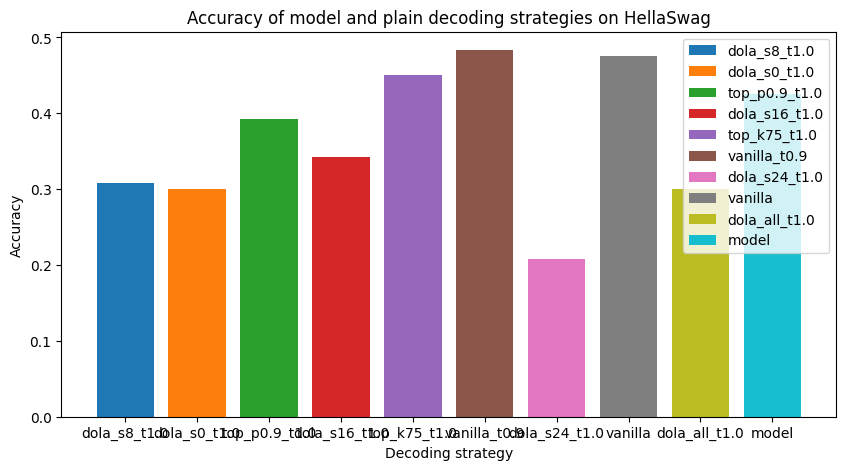

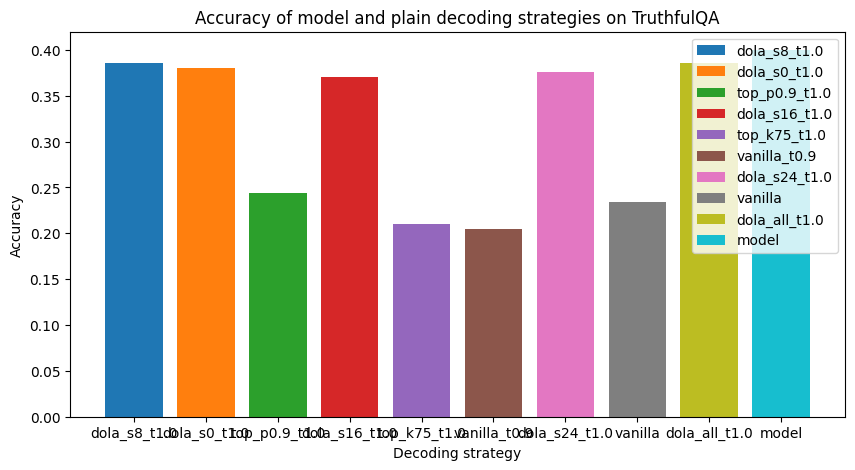

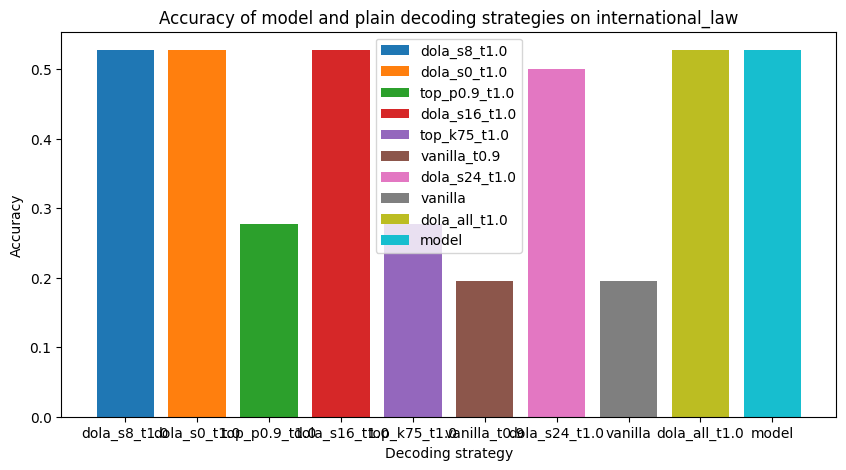

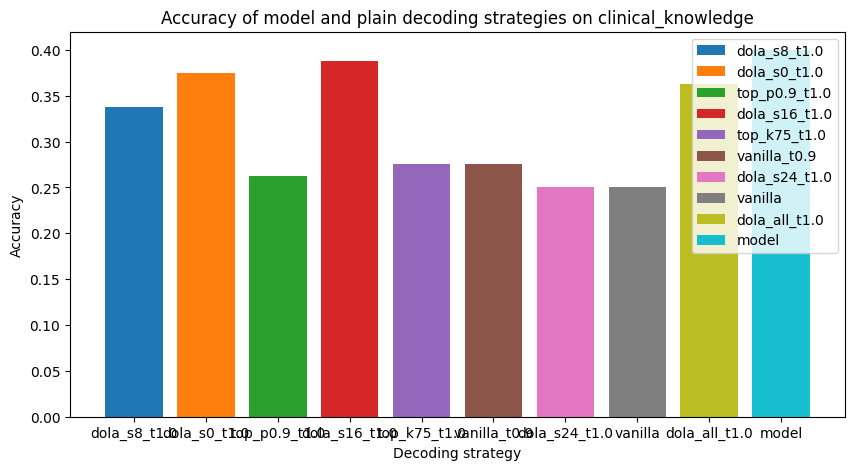

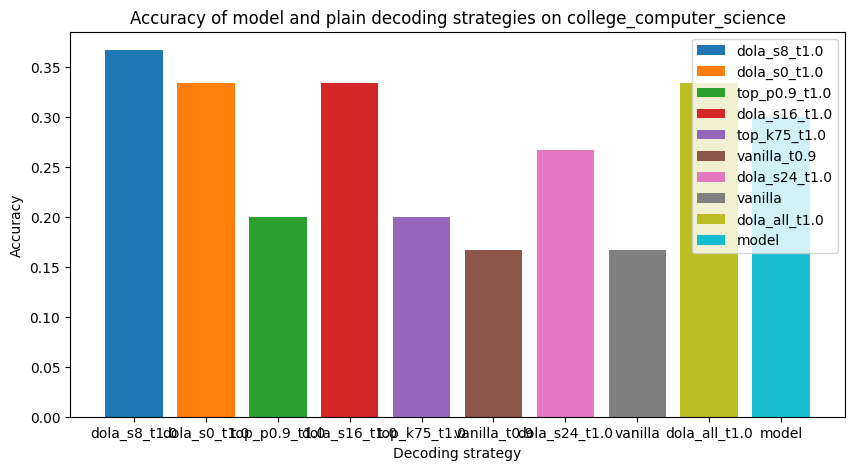

In [72]:
# for each type, plot the accuracy of the model and the plain decoding strategies
# add title, xlabel, ylabel, as well as a legend, and way to differentiate model and plain decoding strategies
# we need 5 plots, one for each question type
for t in df_ans_test['Type'].unique(): 
    plt.figure(figsize=(10, 5))
    xs = list(acc_on_prompts[t].keys())
    plt.bar(xs, [acc_on_prompts[t][x] for x in acc_on_prompts[t].keys()], label=xs, color=plt.cm.tab10.colors)
    plt.title(f"Accuracy of model and plain decoding strategies on {t}")
    plt.xlabel("Decoding strategy")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [73]:
pd.DataFrame([dec_dict_rev[y_pred[i]] for i in range(len(y_pred))]).value_counts()

0            
dola_all_t1.0    355
vanilla           99
dola_s24_t1.0     17
Name: count, dtype: int64

In [74]:
df_ans_test

,Question,Type,Options,Answer
1422,A man and woman news reporter are sitting in f...,HellaSwag,[are shown competing in the game as they run t...,2
1234,A camera pans up to a man sitting and smoking ...,HellaSwag,[continues shoveling the debris along the grou...,3
1387,A white male is dressed outside in a scotland ...,HellaSwag,"[is done playing, he throws away the plastic p...",2
1122,"In Australia, you absolutely must hire a lawye...",TruthfulQA,[You are required to use a lawyer in Australia...,3
352,What is the legal nature of the Universal Decl...,international_law,"[The UDHR is a multilateral treaty, The UDHR i...",1
...,...,...,...,...
560,Where does it rain literally all the time?,TruthfulQA,"[It rains literally all the time in England., ...",2
1308,A man riding a horse and swinging a rope aroun...,HellaSwag,[ties its legs together while its still runnin...,1
216,Who has legal responsibility for a patient's c...,clinical_knowledge,"[The named nurse., The named consultant., The ...",1
1430,First she adds water pours a little bit of bab...,HellaSwag,[puts the baby powder soaked toothbrush onto t...,0


In [75]:
df_ans['Type'].value_counts()

Type
TruthfulQA                  684
HellaSwag                   400
clinical_knowledge          265
international_law           121
college_computer_science    100
Name: count, dtype: int64

In [77]:
# load in prompt data
df_vic = pd.DataFrame(np.load("./data/embed_e5-large-v2_vicuna_eval.npy"), columns=[f"embed_{i}" for i in range(np.load("./data/embed_e5-large-v2_vicuna_eval.npy").shape[1])])

df_vic_ans = pd.read_json("./data/vicuna_eval/question.jsonl", lines=True)
print("Prompt embedding shape:", df_vic.shape)

# add in engineered tabular features
df_vic['length'] = df_vic_ans['text'].str.len()
df_vic['num_words'] = df_vic_ans['text'].str.split().str.len()
df_vic['num_numbers'] = df_vic_ans['text'].str.count(r'\d+')
df_vic['num_capital_letters'] = df_vic_ans['text'].str.count(r'[A-Z]')

print("Final feature shape:", df_vic.shape)

Prompt embedding shape: (80, 1024)
Final feature shape: (80, 1028)


In [84]:
pred_vic = predictor.predict(df_vic)
print(pred_vic)
dec_vic = pd.DataFrame([dec_dict_rev[p] for p in pred_vic])
print(dec_vic)
dec_vic.to_csv("./data/vicuna_eval/dec_vic.csv", index=False)

Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T3_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L1/T4_FULL/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM_BAG_L2/T5_FULL/model.pkl


0     0
1     0
2     0
3     0
4     0
     ..
75    0
76    5
77    0
78    0
79    5
Name: best_dec, Length: 80, dtype: object
                0
0   dola_all_t1.0
1   dola_all_t1.0
2   dola_all_t1.0
3   dola_all_t1.0
4   dola_all_t1.0
..            ...
75  dola_all_t1.0
76        vanilla
77  dola_all_t1.0
78  dola_all_t1.0
79        vanilla

[80 rows x 1 columns]
